In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
import pickle 
import numpy as np
import torch
import os

In [4]:
from core.EmbeddingDataSet import EmbeddingDataSet

In [5]:
dataset_name = 'cora'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir)
dataset.create_all_data(n_batches=1, shuffle=True)
dataset.summarise()

Name of dataset = cora
Input dimension = 1433
Number of training samples = 2485
Training labels = True
Graph information = True


In [16]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [116]:
D = np.sum(dataset.adj_matrix, axis=1)

In [118]:
np.average(D)

5.0796780684104625

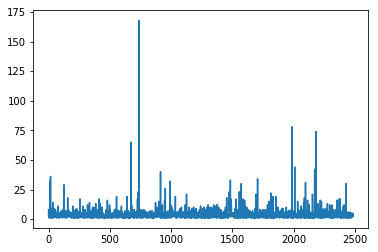

In [20]:
plt.plot(list(range(len(D))), D)

In [40]:
A = dataset.adj_matrix
np.fill_diagonal(A, 1)

In [41]:
two_hop_A = np.matmul(A, A)

In [42]:
two_hop_D = np.sum(two_hop_A, axis=1)

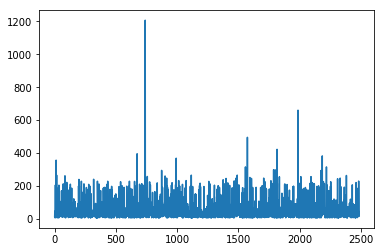

In [43]:
plt.plot(list(range(len(D))), two_hop_D)

In [44]:
A

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [117]:
n_batch = 200
# Select random subset of nodes
all_indices = np.arange(0, len(D))
batch_indices = np.random.choice(all_indices, size=n_batch, replace=False)
neighbors = np.unique(np.nonzero(two_hop_A[batch_indices,:])[1])
print(len(neighbors))

1941


In [46]:
batch_indices

array([1037, 1945, 1169,  781,  920, 1109, 2116, 1025, 1791,  203, 1686,
         47, 1546,  319, 1174, 1173, 2032, 2111, 2085,   99, 2216,  436,
        338,  184, 1371, 1921, 2081, 1287,  362, 1468, 1559,  572, 1117,
       1406,    1,  538, 2384, 1570,  456, 1722, 1346, 1337,  975,   37,
       1000, 2034, 1282, 2255,  631, 2046])

In [52]:
np.nonzero(A[batch_indices,:])[1]

array([ 281,  673, 1037, 1074, 1404,  379,  414, 1217, 1360, 1386, 1945,
       2172, 1143, 1169, 2124, 2438,  198,  739,  781,  976, 1002, 1714,
         16,  914,  920,  327, 1109, 1257, 2459,   81,  739, 1557, 2116,
       2309,  903, 1025, 1190, 1609,  689,  871,  958, 1012, 1325, 1557,
       1791, 1957,  203, 1815, 1207, 1686,   47, 1085, 1349, 2453,  359,
        676, 1408, 1546,  281,  319,  402,  645, 2041, 1174, 1216, 2178,
        580, 1173,  528,  554, 1108, 2032, 1756, 2111,  994, 2085, 2088,
         99,  739,  992, 1773, 2096, 2255,  769, 1379, 2216, 2371,   35,
        436, 1361, 1528, 2171,  338,  940, 1612, 2313, 2416,  184,  555,
       1498, 1505, 1506, 2128,  673, 1371, 1483, 2455,  221, 1921, 1620,
       2081,  536, 1287, 1704, 2097,  362,  739, 1764, 2218, 2223, 2255,
       2356, 1468, 2154, 2227, 2235,  688,  896, 1559, 1633, 1662, 1679,
       1745,  343,  572, 1234, 2244, 1075, 1117,   69,  578,  953, 1003,
       1406, 1739, 1969, 1974, 1981,    1,  144,  6

In [54]:
neighbors = np.unique(np.nonzero(A[batch_indices,:])[1])

In [55]:
for i in batch_indices:
    if i not in neighbors:
        print("ouch")

In [128]:
A.shape[0]

2485

In [145]:
def sample_neighborhood(A, batch_indices, D_layers):
    # A: the full adjacency matrix
    # batch_indices: subset of all vertices 
    # D_layers: sampling strategy per layer
    selected_indices = set(batch_indices)
    #D_layers = [5, 10]
    for i in batch_indices:
        one_hop_neighbors = np.nonzero(A[i, :])[0]
        if len(one_hop_neighbors) > D_layers[0]:
            one_hop_neighbors = np.random.choice(one_hop_neighbors, size=D_layers[0], replace=False)
        selected_indices = selected_indices.union(one_hop_neighbors)
        for j in one_hop_neighbors:
            two_hop_neighbors = np.nonzero(A[j, :])[0]
            if len(two_hop_neighbors) > D_layers[1]:
                two_hop_neighbors = np.random.choice(two_hop_neighbors, size=D_layers[1], replace=False)
            selected_indices = selected_indices.union(two_hop_neighbors)
    return selected_indices np.array(list(all_batch_indices[0]))

In [151]:
def split_graph_batches(batch_size, A, shuffle=False, sampling=True):
    np.fill_diagonal(A, 1)
    all_indices = np.arange(0, A.shape[0])
    if shuffle: np.random.shuffle(all_indices)
    all_batch_indices = [all_indices[i:i+batch_size] for i in np.arange(0, A.shape[0],batch_size)]
    if sampling:
        D_layers = [5, 10]
        all_batch_indices = [sample_neighborhood(A, idx, D_layers) for idx in all_batch_indices]
    return all_batch_indices

In [156]:
batch_size = 100
all_batch_indices = split_graph_batches(batch_size, A)
print([len(i) for i in all_batch_indices])

[1072, 1079, 1081, 1021, 1119, 1035, 1081, 1102, 1119, 1075, 1129, 1042, 1025, 1077, 1106, 1039, 1000, 1089, 1112, 1062, 1065, 1078, 1033, 1026, 935]


In [160]:
np.array(list(all_batch_indices[0]))

array([   0,    1,    2, ..., 2481, 2482, 2484])